In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import eli5

from string import punctuation
from collections import defaultdict
from nltk import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

C:\ProgramData\Anaconda3.1\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3.1\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [4]:
train = pd.read_csv('C:\\Users\\Acer\\OneDrive\\Desktop\\CSV files\\train-tweetdisaster.csv')
test = pd.read_csv('C:\\Users\\Acer\\OneDrive\\Desktop\\CSV files\\test-tweetdisaster.csv')
gt = pd.read_csv('C:\\Users\\Acer\\OneDrive\\Desktop\\CSV files\\submission.csv')

# Analyze the data

Text(0, 0.5, 'samples')

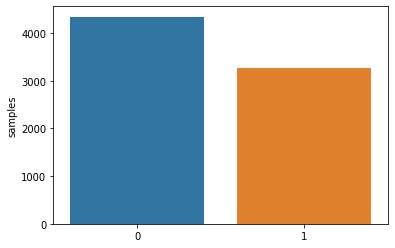

In [5]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

#### Number of characters in tweets

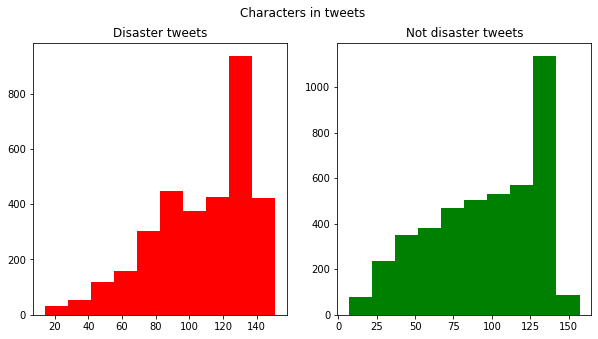

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('Disaster tweets')

tweet_len = train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('Characters in tweets')
plt.show()

#### Number of words in a tweets

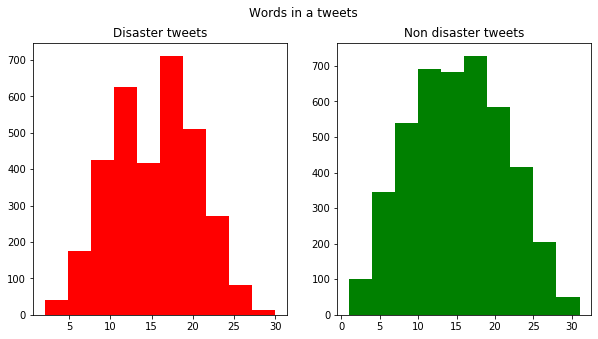

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
num_words = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words, color='red')
ax1.set_title('Disaster tweets')

num_words = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words, color='green')
ax2.set_title('Non disaster tweets')

fig.suptitle('Words in a tweets')
plt.show()

#### Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

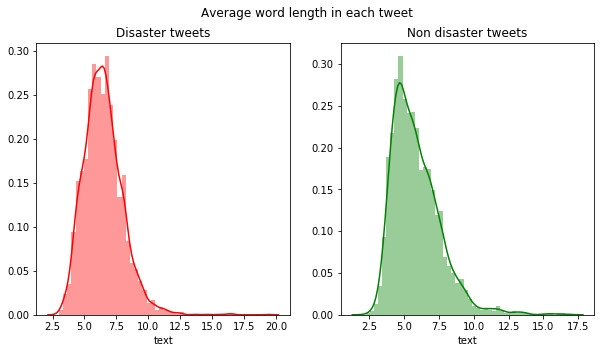

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster tweets')

word = train[train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Non disaster tweets')

fig.suptitle('Average word length in each tweet')

#### Common words in tweets

In [9]:
text_disaster = train[train['target']==1]['text'].str.split()
text_Nodisaster = train[train['target']==0]['text'].str.split()

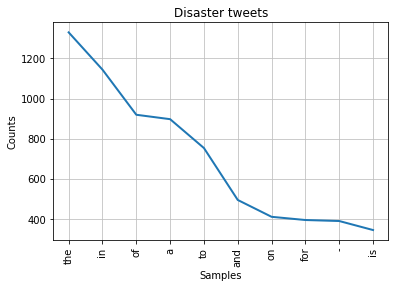

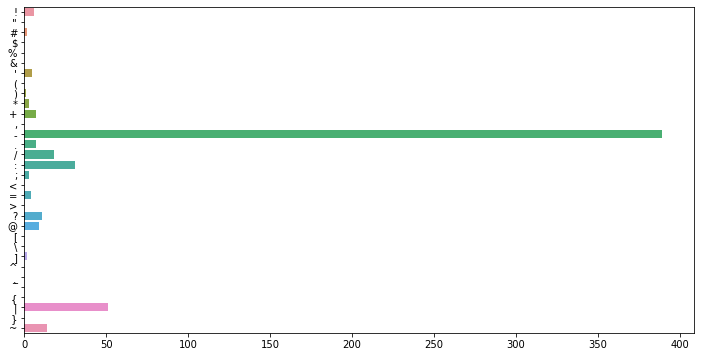

In [10]:
fdist = FreqDist(word.lower() for sentence in text_disaster for word in sentence)
fdist.plot(10, title="Disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

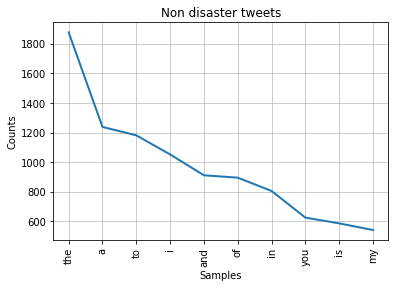

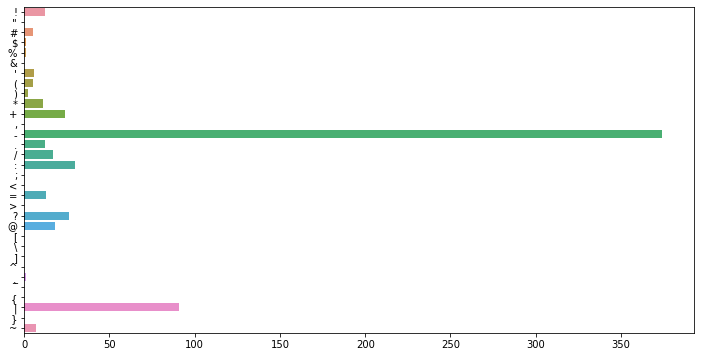

In [11]:
fdist = FreqDist(word.lower() for sentence in text_Nodisaster for word in sentence)
fdist.plot(10, title="Non disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

#### Bigram analysis

In [12]:
def get_top_tweet_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

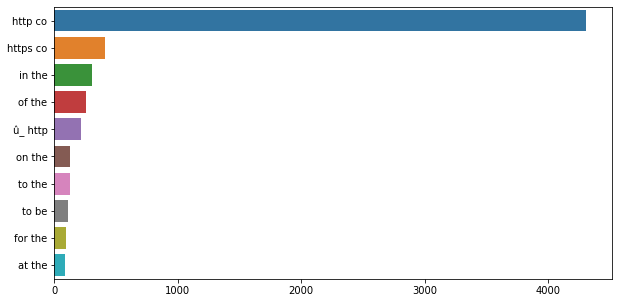

In [13]:
plt.figure(figsize=(10,5))
top_tweet_bigram = get_top_tweet_bigram(train['text'].tolist())[:10]
x,y = map(list, zip(*top_tweet_bigram))
sns.barplot(y,x)

# Clean the data

In [14]:
train = train.fillna('.')
test = test.fillna('.')

In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [16]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [17]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [18]:
def preprocessing(re_URL=False, re_emoji=False, re_punct=False):
    data_train = train['keyword'] +' '+ train['location'] +' '+ train['text']
    data_test = test['keyword'] +' '+ test['location'] +' '+ test['text']

    if re_URL:
        data_train = data_train.apply(lambda x : remove_URL(x))
        data_test = data_test.apply(lambda x : remove_URL(x))
        print("URL Removed")
    if re_emoji:
        data_train = data_train.apply(lambda x : remove_emoji(x))
        data_test = data_test.apply(lambda x : remove_emoji(x))
        print("Emoji Removed")
    if re_punct:
        data_train = data_train.apply(lambda x : remove_punct(x))     
        data_test = data_test.apply(lambda x : remove_punct(x))
        print("Punctuation Removed")
    return data_train, data_test

# Model Training

In [19]:
def fit_and_predict(vec, clf, X_train, y_train):
    pipe = make_pipeline(vec, clf)
    pipe.fit(X_train, y_train)
    
    y_test = gt['target'].tolist()
    acc = pipe.score(X_test, y_test)
    print("Accuracy: ", acc)

#### Baseline

In [20]:
train['sums'] = train['keyword'] +' '+ train['location'] +' '+ train['text']
test['sums'] = test['keyword'] +' '+ test['location'] +' '+ test['text']

X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2))
clf = LogisticRegression()
fit_and_predict(vec, clf, X_train, y_train)

#Accuracy:  0.7955868832362857

Accuracy:  0.7955868832362857


#### Baseline add stopword

In [21]:
train['sums'] = train['keyword'] +' '+ train['location'] +' '+ train['text']
test['sums'] = test['keyword'] +' '+ test['location'] +' '+ test['text']

X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf, X_train, y_train)

Accuracy:  0.8035550107263255


#### Remove URL, emoji, and punctuation

In [22]:
train['sums'], test['sums'] = preprocessing(re_URL=True, re_emoji=True, re_punct=True)
X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf, X_train, y_train)

URL Removed
Emoji Removed
Punctuation Removed
Accuracy:  0.7971192154459087


#### Remove URL and punctuation

In [23]:
train['sums'], test['sums'] = preprocessing(re_URL=True, re_emoji=False, re_punct=True)
X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf, X_train, y_train)

URL Removed
Punctuation Removed
Accuracy:  0.7971192154459087


#### Remove punctuation

In [24]:
train['sums'], test['sums'] = preprocessing(re_URL=False, re_emoji=False, re_punct=True)
X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf, X_train, y_train)

Punctuation Removed
Accuracy:  0.796812749003984


# ELI5 analysis

#### Baseline

In [25]:
eli5.show_weights(clf, vec=vec, top=10)

In [26]:
eli5.show_prediction(clf, X_test[0], vec=vec, target_names=['0', '1'])

In [27]:
eli5.show_prediction(clf, X_test[-2], vec=vec, target_names=['0', '1'])

#### Baseline add stopword

In [28]:
eli5.show_weights(clf, vec=vec, top=10)

In [29]:
eli5.show_prediction(clf, X_test[0], vec=vec, target_names=['0', '1'])

In [30]:
eli5.show_prediction(clf, X_test[-2], vec=vec, target_names=['0', '1'])

#### Remove URL, emoji, and punctuation

In [31]:
eli5.show_weights(clf, vec=vec, top=10)

In [32]:
eli5.show_prediction(clf, X_test[0], vec=vec, target_names=['0', '1'])

In [33]:
eli5.show_prediction(clf, X_test[-2], vec=vec, target_names=['0', '1'])